### Effective Key Transition : Analysis 2

- key position adjusted in increments of 0.25 mm
- vernier scale and infrared sensor used for key increment calibration
- pressure pulse data (oscilloscope) and 1V signal (generator) used for pressure calibration
- key manipulated by mechanical device with **point impact** finger

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
import TransferFunctions as tf
import SoundUtils as sut
import scipy.signal as sig
import peakutils

%matplotlib notebook

In [32]:
rpm = 4250
acquisitions = ['3001']
runs = 15

dfiles = []
for acqno, acq in enumerate(acquisitions):
    dfiles.append([])
    for r in range(runs):
        acqfiles = "DATA/microclose/%drpm/%s_closing_%d.aup" % (rpm, acq, r)
        dfiles[acqno].append(acqfiles)
        
# reffile = "DATA/microclose/%drpm/2tieclip_reference_sines.aup"

In [33]:
gamma=1.4
P_a=101000
rho_a=1.22
c = 343

chimney=0.0139
bore=0.0186
foot=0.16

# V=(np.pi*bore**2/4)*foot
# const = c**2/(4*np.pi**2*V)

In [37]:
def effective_transition2(aupfile, freqIR, nfft, ch_labium=0, ch_int=1, ch_IR=2, ch_ext=3):
    '''
    Main routine for Effective Key Transition analysis 2.
    Uses spectrum analysis to determine when
    effective key state changes from open to closed.
    
    Input
    -----
    aupfile : audacity project file
    ch_labium, ch_int, ch_IR, ch_ext : (optional) channel numbers
        for labium mic, infrared signal, internal mic and external mic tracks
    IRfreq : frequency of infrared signal modulation
    nfft : window length for transfer function calculation
    
    Output
    ------
    returns a dictionary of the data with the following keys:
    'tf' = transfer function (internal/external response)
    'coh' = coherence (internal vs external)
    'int_mic' = internal response
    'ext_mic' = external responce
    '''    
    auf = audacity.Aup(aupfile)
    print(aupfile)
    sr = auf.rate
    rawdata = []
    maxlen = 0
    for chno in range(auf.nchannels):
        rawdata.append(auf.get_channel_data(chno))
        maxlen = max(maxlen, len(rawdata[-1]))

    data = np.zeros((len(rawdata), maxlen))
    for chno, chdata in enumerate(rawdata):
        data[chno,:len(chdata)] = chdata
        
    lab_ = data[ch_labium,:]
    int_ = data[ch_int,:]
    ext_ = data[ch_ext,:]
    IR = data[ch_IR,:]
    
    datadict = {}
    for chname, chdata in zip(['lab_', 'int_', 'ext_'], [lab_, int_, ext_]):
        ampl_RMS = np.sqrt(np.mean((chdata-np.mean(chdata))**2))
        spectrum = np.fft.rfft(chdata)
#         freqpeaks = peakutils.indexes(spectrum, ...)
#         intensity = np.array([2*np.pi**2*f**2*amplitude**2*rho_a*c for f in freqpeaks])
        datadict['%samplitude'%chname] = ampl_RMS
        datadict['%sspectrum'%chname] = spectrum
    
    datadict['ir_RMS'] = np.sqrt(np.mean((IR-np.mean(IR))**2))
    return datadict

In [38]:
freqIR = 9820
nfft = 1024*2

In [39]:
results = []
for acqno, acqfiles in enumerate(dfiles):
    results.append([])
    for file in acqfiles:
        filedata = effective_transition2(file, freqIR, nfft)
        results[acqno].append(filedata)

DATA/microclose/4250rpm/3001_closing_0.aup
DATA/microclose/4250rpm/3001_closing_1.aup
DATA/microclose/4250rpm/3001_closing_2.aup
DATA/microclose/4250rpm/3001_closing_3.aup
DATA/microclose/4250rpm/3001_closing_4.aup
DATA/microclose/4250rpm/3001_closing_5.aup
DATA/microclose/4250rpm/3001_closing_6.aup
DATA/microclose/4250rpm/3001_closing_7.aup
DATA/microclose/4250rpm/3001_closing_8.aup
DATA/microclose/4250rpm/3001_closing_9.aup
DATA/microclose/4250rpm/3001_closing_10.aup
DATA/microclose/4250rpm/3001_closing_11.aup
DATA/microclose/4250rpm/3001_closing_12.aup
DATA/microclose/4250rpm/3001_closing_13.aup
DATA/microclose/4250rpm/3001_closing_14.aup


<IPython.core.display.Javascript object>


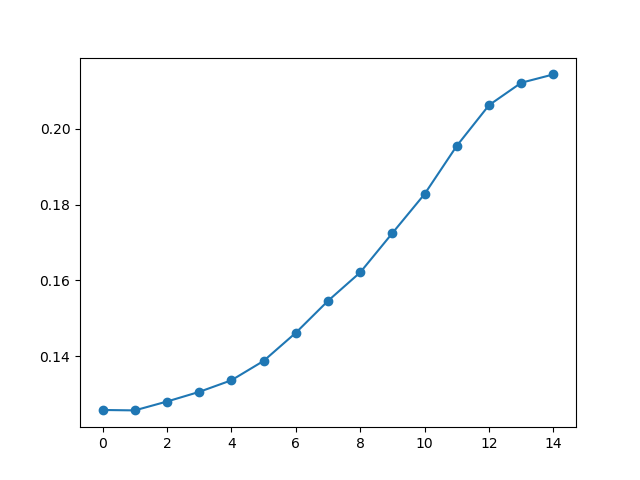

In [40]:
for acqresults in results:
    fig = plt.figure()
    plt.plot([result['ir_RMS'] for result in acqresults], 'o-')

<IPython.core.display.Javascript object>


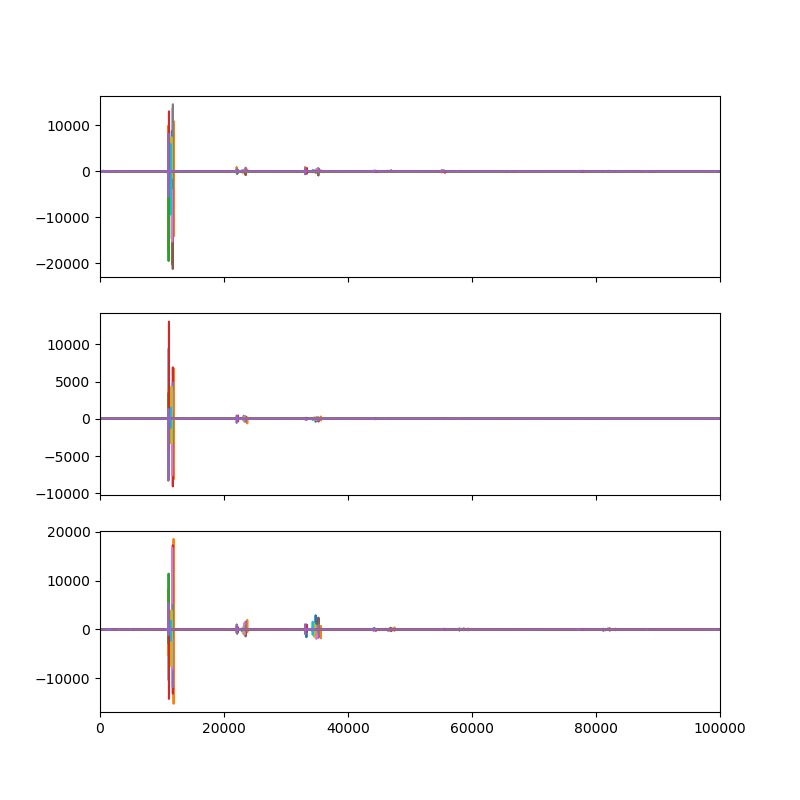

/home/leon/Directories/anaconda3/envs/legato-transients/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [42]:
for acqresults in results:
    fig,ax = plt.subplots(3,sharex=True, figsize=((8,8)))
    for r in range(runs):
        ax[0].set_xlim((0,100000))
        ax[0].plot(acqresults[r]['lab_spectrum'])
        ax[1].plot(acqresults[r]['int_spectrum'])
        ax[2].plot(acqresults[r]['ext_spectrum'])